In [1]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [2]:
#Import required packages
import os
#KerasCore makes the notebook backend agnostic set backend to tensorflow
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import BinaryAccuracy, CategoricalAccuracy, Recall, Precision
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 32
    EPOCHS = 25
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

In [5]:
MAIN_FOLDER = f'/kaggle/input/rsna-preprocessed'

In [6]:
#Load training data from a CSV file into a Pandas DataFrame
dataframe = pd.read_csv(f"{MAIN_FOLDER}/train.csv")

#Create a new column 'image_path' by concatenating folder and file information
dataframe["image_path"] = (
    f"{MAIN_FOLDER}/train_images"
    + "/" + dataframe.patient_id.astype(str)
    + "/" + dataframe.series_id.astype(str)
    + "/" + dataframe.instance_number.astype(str) + ".png"
)

#Remove duplicate rows from the DataFrame, if any
dataframe = dataframe.drop_duplicates()

#Display the first few rows of the DataFrame to inspect the data
dataframe.head()


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512


In [7]:
#Function to handle the split for each group
def split_group(group, test_size=0.2):
    """
    Splits a given group into training and validation sets.

    Parameters:
    - group: Pandas DataFrame
        The group to be split into training and validation sets.
    - test_size: float, optional (default=0.2)
        The proportion of the group to be allocated to the validation set when the group has more than one sample.

    Returns:
    - Tuple of Pandas DataFrames
        Returns a tuple containing the training and validation sets.
        For single-sample groups, one of the DataFrames will be empty.
    """
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

#Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

#Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

In [9]:
def decode_image_and_label(image_path, label):
    """
    Decodes an image from the given file path and processes the label.

    Parameters:
    - image_path: str
        File path to the image.
    - label: tf.Tensor
        Tensor containing label information.

    Returns:
    - Tuple of tf.Tensor
        Returns a tuple containing the decoded image and processed label.
    """
    # Read the image file
    file_bytes = tf.io.read_file(image_path)
    # Decode the PNG image with 3 channels and convert to uint8
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    # Resize the image to the specified size using bilinear interpolation
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    # Convert image to float32 and normalize values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Cast the label to float32
    label = tf.cast(label, tf.float32)

    # Extract specific label components for individual organs
    # bowel, extra, kidney, liver, spleen
    labels = (
        label[0:1][:, tf.newaxis],  # Shape: (batch_size, 1)
        label[1:2][:, tf.newaxis],  # Shape: (batch_size, 1)
        label[2:5],  # Shape: (batch_size, 3) for kidney
        label[5:8],  # Shape: (batch_size, 3) for liver
        label[8:11]  # Shape: (batch_size, 3) for spleen
    )

    return image, labels



def apply_augmentation(images, labels):
    """
    Applies data augmentation to a batch of images and their corresponding labels.

    Parameters:
    - images: tf.Tensor
        Tensor containing a batch of images.
    - labels: Tuple of tf.Tensor
        Tuple containing label information for different organs.

    Returns:
    - Tuple of tf.Tensor
        Returns a tuple containing the augmented images and unchanged labels.
    """
    #Define an augmenter with various image transformations
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomContrast(factor=0.1),
        ]
    )
    #Apply augmentation to the images
    augmented_images = augmenter(images)
    
    return (augmented_images, labels)


def build_dataset(image_paths, labels):
    """
    Builds a TensorFlow dataset from image paths and labels, including decoding and augmentation.

    Parameters:
    - image_paths: List of str
        List containing file paths to the images.
    - labels: tf.Tensor
        Tensor containing label information.

    Returns:
    - tf.data.Dataset
        Returns a TensorFlow dataset ready for model training.
    """
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )

    return ds


In [10]:
#Set paths and labels
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

#Build dataset
ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([32, 256, 256, 3]),
 [TensorShape([32, 1, 1]),
  TensorShape([32, 1, 1]),
  TensorShape([32, 3]),
  TensorShape([32, 3]),
  TensorShape([32, 3])])

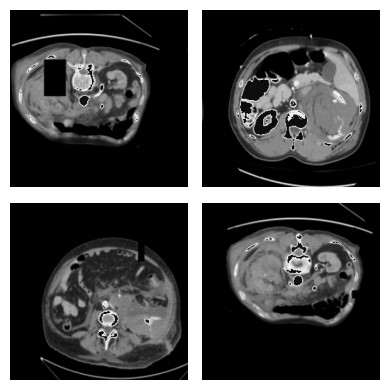

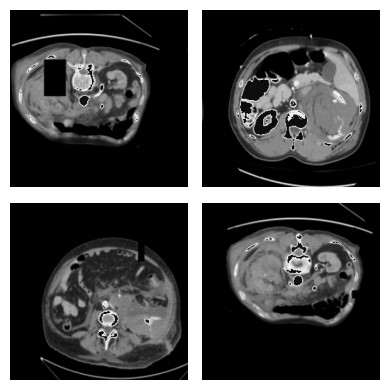

In [11]:
#Display images
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

In [12]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=240800
warmup_steps=24080
decay_steps=216720


In [13]:
# Get all unique labels in the entire dataset
all_labels = np.unique(dataframe[config.TARGET_COLS])

# Convert one-hot encoded labels to class indices
train_labels_indices = np.argmax(train_data[config.TARGET_COLS].values, axis=1)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=all_labels, y=train_labels_indices)
class_weights_dict = dict(zip(all_labels, class_weights))

# Modify class weights dictionary to use output names instead of indices
output_names = ['bowel', 'extra', 'liver', 'kidney', 'spleen']
class_weights_dict = {output_names[i]: weight for i, weight in enumerate(class_weights)}

# Ensure that the keys are strings
class_weights_dict = {str(key): value for key, value in class_weights_dict.items()}


In [14]:
def build_model():
    """
    Builds a custom neural network model.

    Returns:
    - tf.keras.Model
        Returns the compiled TensorFlow model.
    """
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Simple Computer Vision Model
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)

    # Define 'necks' for each head
    x_bowel = Dense(32, activation='relu')(x)
    x_bowel = BatchNormalization()(x_bowel)
    
    x_extra = Dense(32, activation='relu')(x)
    x_extra = BatchNormalization()(x_extra)

    x_liver = Dense(32, activation='relu')(x)
    x_liver = BatchNormalization()(x_liver)
    
    x_kidney = Dense(32, activation='relu')(x)
    x_kidney = BatchNormalization()(x_kidney)
    
    x_spleen = Dense(32, activation='relu')(x)
    x_spleen = BatchNormalization()(x_spleen)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)


    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print('[INFO] Building the model...')
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    loss = {
        "bowel": BinaryCrossentropy(),
        "extra": BinaryCrossentropy(),
        "liver": CategoricalCrossentropy(),
        "kidney": CategoricalCrossentropy(),
        "spleen": CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": [BinaryAccuracy(), Recall(), Precision()],
        "extra": [BinaryAccuracy(), Recall(), Precision()],
        "liver": [CategoricalAccuracy(), Recall(), Precision()],
        "kidney": [CategoricalAccuracy(), Recall(), Precision()],
        "spleen": [CategoricalAccuracy(), Recall(), Precision()],
    }

    print("[INFO] Compiling the model...")
    model.compile(
        optimizer='adam',  # You can use any optimizer of your choice
        loss=loss,
        metrics=metrics,
        loss_weights=class_weights_dict  # Use class weights here
    )

    return model


In [15]:
#Define Early Stopping callback to prevent overfitting
earlystopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True
)

In [16]:
# Train the model with Early Stopping
print("[INFO] Training...")
model = build_model()  # Create an instance of the model
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
    callbacks=[earlystopping]
)


[INFO] Training...
[INFO] Building the model...
[INFO] Compiling the model...
Epoch 1/25
301/301 [==============================] - 101s 297ms/step - loss: 3.4493 - bowel_loss: 0.6701 - extra_loss: 0.6691 - liver_loss: 0.6002 - kidney_loss: 0.6707 - spleen_loss: 0.8368 - bowel_binary_accuracy: 0.6512 - bowel_recall: 0.3761 - bowel_precision: 0.8929 - extra_binary_accuracy: 0.6407 - extra_recall_1: 0.8884 - extra_precision_1: 0.6873 - liver_categorical_accuracy: 0.8387 - liver_recall_2: 0.6076 - liver_precision_2: 0.9178 - kidney_categorical_accuracy: 0.7895 - kidney_recall_3: 0.6555 - kidney_precision_3: 0.8332 - spleen_categorical_accuracy: 0.6981 - spleen_recall_4: 0.5309 - spleen_precision_4: 0.7379 - val_loss: 5.3893 - val_bowel_loss: 0.7698 - val_extra_loss: 0.6483 - val_liver_loss: 0.6180 - val_kidney_loss: 0.5865 - val_spleen_loss: 2.7693 - val_bowel_binary_accuracy: 0.5134 - val_bowel_recall: 0.9865 - val_bowel_precision: 0.5171 - val_extra_binary_accuracy: 0.6967 - val_extra_r

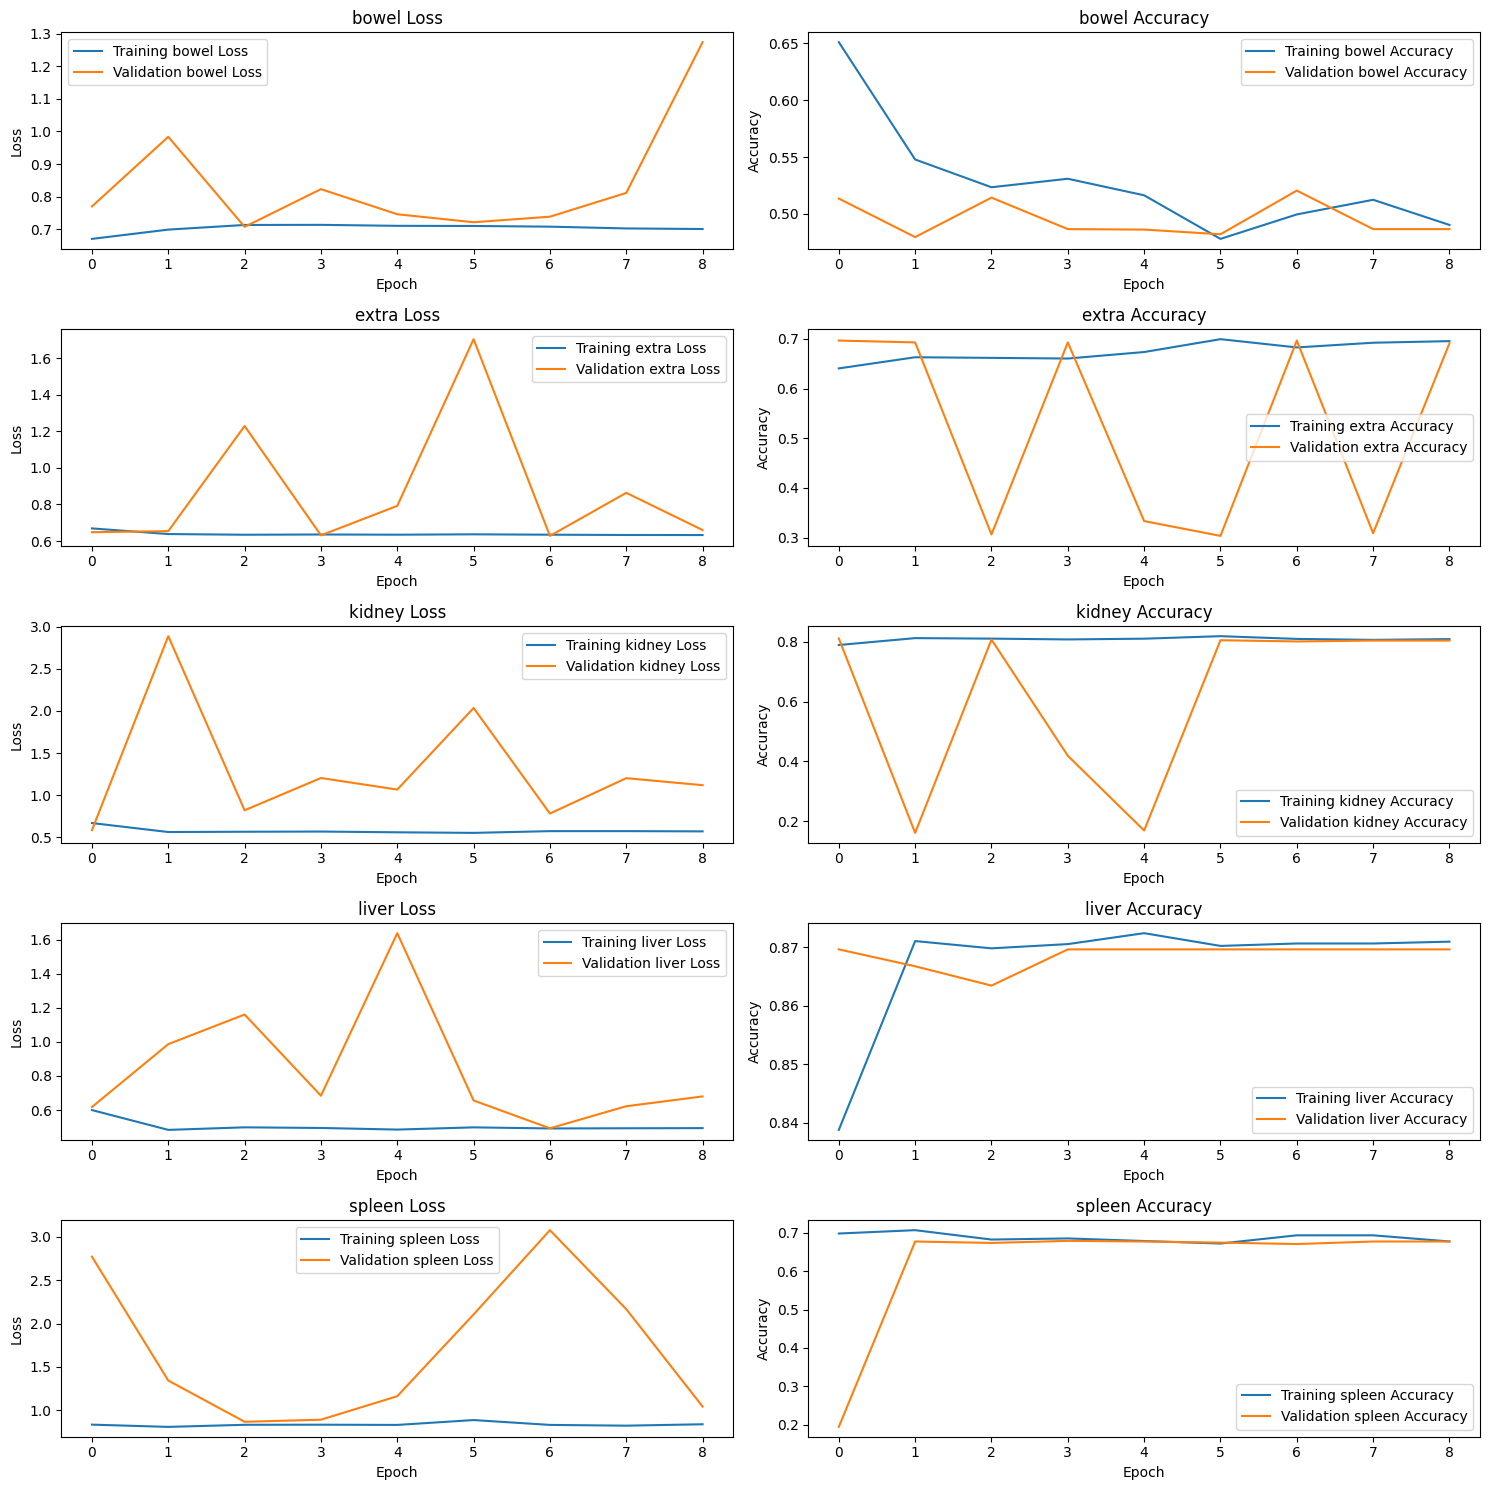

In [17]:
# Create a 5x2 grid for the subplots (2 columns for loss and accuracy)
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot loss and accuracy
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training loss
    axes[i*2].plot(history.history[name + '_loss'], label='Training ' + name + ' Loss')
    # Plot validation loss
    axes[i*2].plot(history.history['val_' + name + '_loss'], label='Validation ' + name + ' Loss')
    axes[i*2].set_title(name + ' Loss')
    axes[i*2].set_xlabel('Epoch')
    axes[i*2].set_ylabel('Loss')
    axes[i*2].legend()

    # Identify the correct name for accuracy metric
    acc_name = name + '_binary_accuracy' if name in ['bowel', 'extra'] else name + '_categorical_accuracy'

    # Plot training accuracy
    axes[i*2 + 1].plot(history.history[acc_name], label='Training ' + name + ' Accuracy')
    # Plot validation accuracy
    axes[i*2 + 1].plot(history.history['val_' + acc_name], label='Validation ' + name + ' Accuracy')
    axes[i*2 + 1].set_title(name + ' Accuracy')
    axes[i*2 + 1].set_xlabel('Epoch')
    axes[i*2 + 1].set_ylabel('Accuracy')
    axes[i*2 + 1].legend()

plt.tight_layout()
plt.show()


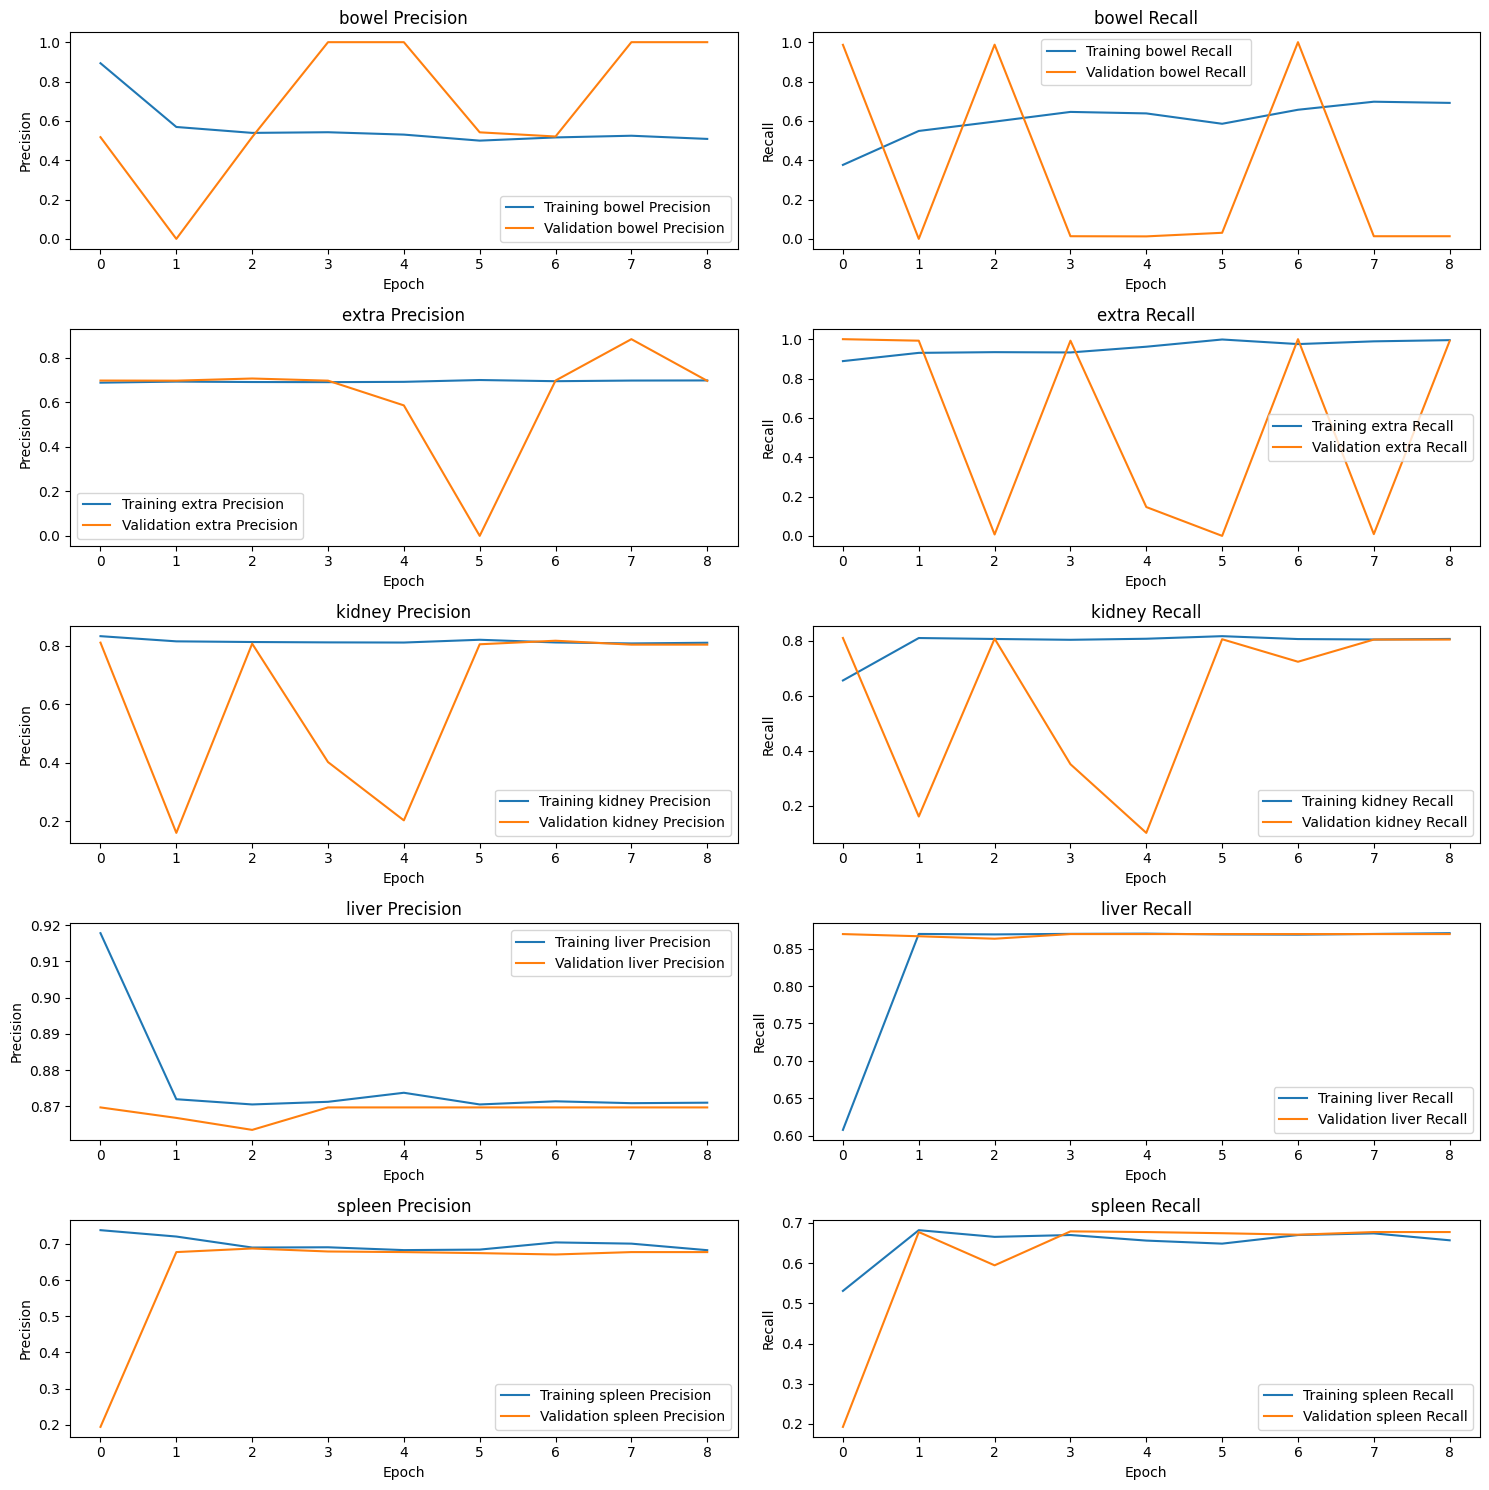

In [18]:
# Create a 5x2 grid for the subplots (2 columns for loss and precision/recall)
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot loss, precision, and recall
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Identify the correct names for precision and recall metrics
    precision_name = [key for key in history.history.keys() if name + '_precision' in key][0]
    recall_name = [key for key in history.history.keys() if name + '_recall' in key][0]

    # Plot training precision
    axes[i*2].plot(history.history[precision_name], label='Training ' + name + ' Precision')
    # Plot validation precision
    axes[i*2].plot(history.history['val_' + precision_name], label='Validation ' + name + ' Precision')
    axes[i*2].set_title(name + ' Precision')
    axes[i*2].set_xlabel('Epoch')
    axes[i*2].set_ylabel('Precision')
    axes[i*2].legend()

    # Plot training recall
    axes[i*2 + 1].plot(history.history[recall_name], label='Training ' + name + ' Recall')
    # Plot validation recall
    axes[i*2 + 1].plot(history.history['val_' + recall_name], label='Validation ' + name + ' Recall')
    axes[i*2 + 1].set_title(name + ' Recall')
    axes[i*2 + 1].set_xlabel('Epoch')
    axes[i*2 + 1].set_ylabel('Recall')
    axes[i*2 + 1].legend()

plt.tight_layout()
plt.show()


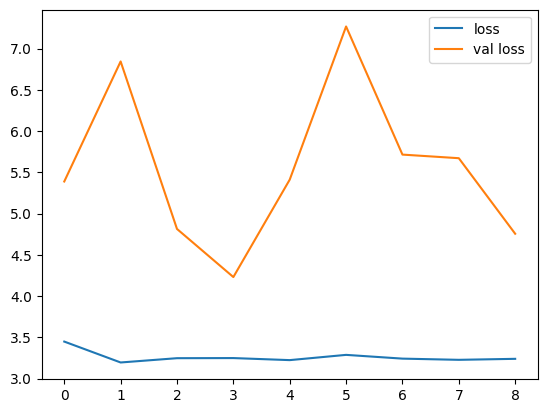

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [20]:
# Store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_binary_accuracy'][best_epoch]
best_recall_bowel = history.history['val_bowel_recall'][best_epoch]
best_precision_bowel = history.history['val_bowel_precision'][best_epoch]

best_acc_extra = history.history['val_extra_binary_accuracy'][best_epoch]
best_recall_extra = history.history['val_extra_recall_1'][best_epoch]
best_precision_extra = history.history['val_extra_precision_1'][best_epoch]

best_acc_liver = history.history['val_liver_categorical_accuracy'][best_epoch]
best_recall_liver = history.history['val_liver_recall_2'][best_epoch]
best_precision_liver = history.history['val_liver_precision_2'][best_epoch]

best_acc_kidney = history.history['val_kidney_categorical_accuracy'][best_epoch]
best_recall_kidney = history.history['val_kidney_recall_3'][best_epoch]
best_precision_kidney = history.history['val_kidney_precision_3'][best_epoch]

best_acc_spleen = history.history['val_spleen_categorical_accuracy'][best_epoch]
best_recall_spleen = history.history['val_spleen_recall_4'][best_epoch]
best_precision_spleen = history.history['val_spleen_precision_4'][best_epoch]

# Find mean accuracy, mean recall, and mean precision
best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])
best_recall = np.mean([best_recall_bowel, best_recall_extra, best_recall_liver, best_recall_kidney, best_recall_spleen])
best_precision = np.mean([best_precision_bowel, best_precision_extra, best_precision_liver, best_precision_kidney, best_precision_spleen])

print(f'>>>> BEST Loss    : {best_loss:.3f}\n>>>> BEST Acc     : {best_acc:.3f}\n>>>> BEST Recall   : {best_recall:.3f}\n>>>> BEST Precision: {best_precision:.3f}\n>>>> BEST Epoch   : {best_epoch}\n')
print('ORGAN Metrics:')
print(f'  >>>> {"Bowel".ljust(15)} : Acc={best_acc_bowel:.3f}, Recall={best_recall_bowel:.3f}, Precision={best_precision_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : Acc={best_acc_extra:.3f}, Recall={best_recall_extra:.3f}, Precision={best_precision_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : Acc={best_acc_liver:.3f}, Recall={best_recall_liver:.3f}, Precision={best_precision_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : Acc={best_acc_kidney:.3f}, Recall={best_recall_kidney:.3f}, Precision={best_precision_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : Acc={best_acc_spleen:.3f}, Recall={best_recall_spleen:.3f}, Precision={best_precision_spleen:.3f}')


>>>> BEST Loss    : 4.231
>>>> BEST Acc     : 0.629
>>>> BEST Recall   : 0.581
>>>> BEST Precision: 0.730
>>>> BEST Epoch   : 3

ORGAN Metrics:
  >>>> Bowel           : Acc=0.487, Recall=0.014, Precision=1.000
  >>>> Extravasation   : Acc=0.693, Recall=0.992, Precision=0.696
  >>>> Liver           : Acc=0.870, Recall=0.870, Precision=0.870
  >>>> Kidney          : Acc=0.419, Recall=0.351, Precision=0.403
  >>>> Spleen          : Acc=0.679, Recall=0.679, Precision=0.679


76/76 [==============================] - 19s 234ms/step


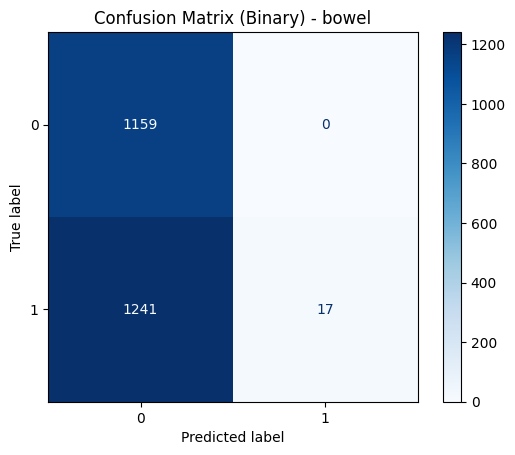

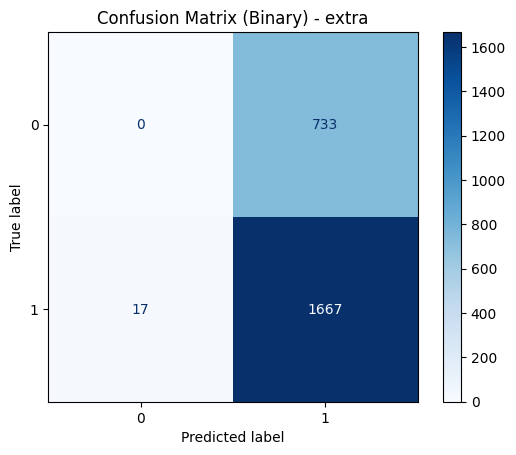

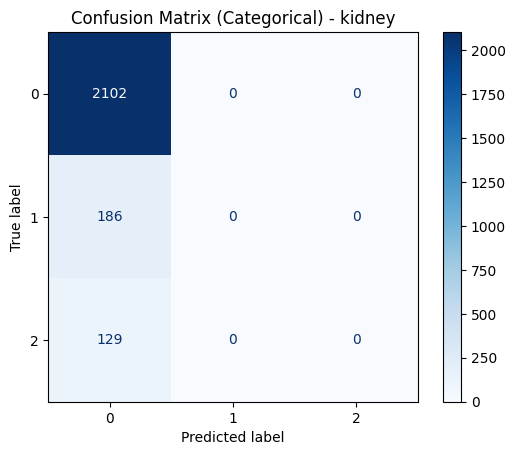

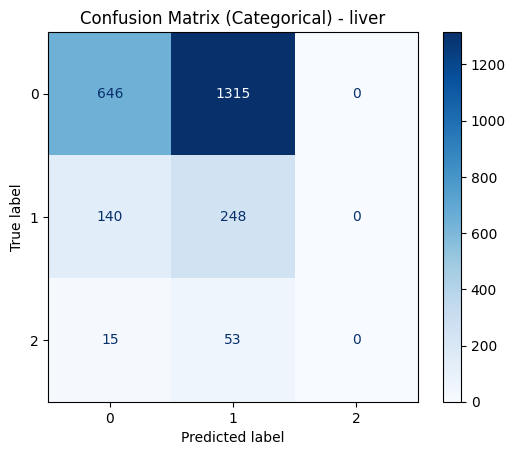

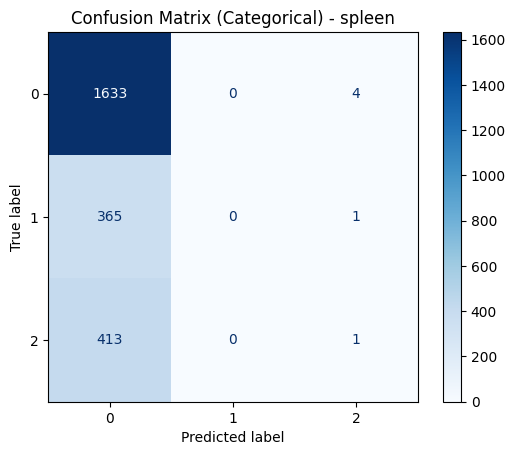

In [24]:
# Predict on the validation set
val_predictions = model.predict(val_ds)

# Flatten predictions to get 1D arrays
val_pred_labels_bowel = np.squeeze(np.round(val_predictions[0]))
val_pred_labels_extra = np.squeeze(np.round(val_predictions[1]))
val_pred_labels_kidney = np.argmax(val_predictions[2], axis=1)
val_pred_labels_liver = np.argmax(val_predictions[3], axis=1)
val_pred_labels_spleen = np.argmax(val_predictions[4], axis=1)

# Flatten true labels to get 1D arrays
val_true_labels_bowel = np.squeeze(valid_labels[:, 0])
val_true_labels_extra = np.squeeze(valid_labels[:, 1])
val_true_labels_kidney = np.argmax(valid_labels[:, 2:5], axis=1)
val_true_labels_liver = np.argmax(valid_labels[:, 5:8], axis=1)
val_true_labels_spleen = np.argmax(valid_labels[:, 8:11], axis=1)

# Binary output categories (bowel, extra)
for i, organ in enumerate(["bowel", "extra"]):
    organ_true_labels = val_true_labels_bowel if i == 0 else val_true_labels_extra
    organ_pred_labels = val_pred_labels_bowel if i == 0 else val_pred_labels_extra

    # Binary classification confusion matrix
    conf_matrix = confusion_matrix(organ_true_labels, organ_pred_labels)

    # Display the binary confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(range(2)))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix (Binary) - {organ}')
    plt.show()

# Categorical output categories (kidney, liver, spleen)
for i, organ in enumerate(["kidney", "liver", "spleen"]):
    organ_true_labels = val_true_labels_kidney if i == 0 else (val_true_labels_liver if i == 1 else val_true_labels_spleen)
    organ_pred_labels = val_pred_labels_kidney if i == 0 else (val_pred_labels_liver if i == 1 else val_pred_labels_spleen)

    # Determine the number of unique classes for the organ
    num_classes = len(np.unique(organ_true_labels))

    # Categorical confusion matrix
    conf_matrix = confusion_matrix(organ_true_labels, organ_pred_labels, labels=list(range(num_classes)))

    # Display the categorical confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(range(num_classes)))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix (Categorical) - {organ}')
    plt.show()
